# Parkinson's Disease Detection from fMRI Data on AWS SageMaker

This notebook implements a machine learning pipeline for detecting Parkinson's disease from functional MRI (fMRI) data.
Based on neuroimaging research methodologies for movement disorder classification.

## Overview
- **Objective**: Classify Parkinson's disease patients vs. healthy controls using fMRI features
- **Approach**: Extract functional connectivity and regional activity features
- **Methods**: Support Vector Machine, Random Forest, and Deep Learning classifiers
- **Validation**: Cross-validation with performance metrics

## Prerequisites
- AWS SageMaker notebook instance in us-east-2 region
- fMRI data stored in S3 (preprocessed with fMRIPrep)
- Required libraries: nilearn, scikit-learn, tensorflow, nibabel

## Dataset Structure Expected
```
s3://bucket/datasets/Parkinsonsdisease58/ds004392-download/
├── sub-0203/
│   └── ses-01/
│       ├── func/
│       │   └── sub-0203_ses-01_task-rest_bold.nii.gz
│       └── anat/
│           └── sub-0203_ses-01_T1w.nii.gz
└── sub-1001/
    └── ses-01/
        ├── func/
        │   └── sub-1001_ses-01_task-rest_bold.nii.gz
        └── anat/
            └── sub-1001_ses-01_T1w.nii.gz
```

## 1. Environment Setup and Library Installation

In [1]:
# Install required packages for Parkinson's detection
!pip install nilearn scikit-learn tensorflow pandas numpy matplotlib seaborn
!pip install nibabel boto3 sagemaker plotly imbalanced-learn
!pip install xgboost lightgbm optuna scipy statsmodels

# Import necessary libraries
import os
import boto3
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sklearn
warnings.filterwarnings('ignore')

# fMRI and neuroimaging imports
import nibabel as nib
from nilearn import datasets, plotting, image
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_connectome, plot_matrix
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 127.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 140.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nilearn]m1/2 [nilearn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn][imbalanced-learn]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.8 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      INFO:xgboost.packager.build_wheel:Parsed build configuration: {'hide_cxx_symbols': True, 'use_openmp': True, 'use_cuda': False, 'use_nccl': False, 'use_dlopen_nccl': False, 'plugin_federated': False, 'plugin_rmm': False, 'use_system_libxgboost': False}
      INFO:xgboost.packager.build_wheel:Copying project files to temp

2026-01-17 16:48:14.739769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-17 16:48:18.392930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-17 16:48:18.426861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-17 16:48:23.550781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-17 16:48:30.642770: W tensorflow/com

Libraries imported successfully!
TensorFlow version: 2.16.2
Scikit-learn version: 1.7.2


## 2. AWS SageMaker Configuration

In [3]:
# Initialize SageMaker session and get default bucket
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'datasets'

# Initialize S3 client
s3_client = boto3.client('s3')

# Set up local directories
data_dir = '/tmp/fmri_data'
output_dir = '/tmp/results'
models_dir = '/tmp/models'

os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print(f"SageMaker role: {role}")
print(f"S3 bucket: {bucket}")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print(f"Models directory: {models_dir}")

SageMaker role: arn:aws:iam::257967673968:role/parkinson-fmri-notebook-stack-SageMakerNotebookRole-6Dt9LfTmian7
S3 bucket: sagemaker-us-east-2-257967673968
Data directory: /tmp/fmri_data
Output directory: /tmp/results
Models directory: /tmp/models


## 3. Data Loading from S3 - Parkinson's Dataset

In [11]:
def load_fmri_dataset(s3_bucket, s3_prefix='datasets'):
    """
    Load fMRI dataset from S3 with labels (controls vs patients)
    
    Expected S3 structure:
    s3://bucket/datasets/Parkinsonsdisease58/ds004392-download/sub-XXXX/ses-XX/func/
    s3://bucket/datasets/Parkinsonsdisease58/ds004392-download/sub-XXXX/ses-XX/anat/
    
    File naming convention:
    - Functional: sub-XXXX_ses-XX_task-rest_bold.nii.gz
    - Anatomical: sub-XXXX_ses-XX_T1w.nii.gz
    
    Returns:
    func_paths: List of functional fMRI file paths
    anat_paths: List of anatomical T1w file paths  
    labels: List of labels (0=control, 1=patient)
    subject_ids: List of subject identifiers
    """
    func_paths = []
    anat_paths = []
    labels = []
    subject_ids = []
    
    print(f"Loading Parkinson's disease dataset from S3 bucket: {s3_bucket}")
    print(f"Searching in prefix: {s3_prefix}/Parkinsonsdisease58/ds004392-download/")
    
    try:
        # List all objects in the Parkinson's dataset
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(
            Bucket=s3_bucket, 
            Prefix=f'{s3_prefix}/Parkinsonsdisease58/ds004392-download/'
        )
        
        subjects_found = set()
        
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    key = obj['Key']
                    
                    # Parse the S3 key to extract subject info
                    # Expected format: datasets/Parkinsonsdisease58/ds004392-download/sub-XXXX/ses-XX/func|anat/filename
                    key_parts = key.split('/')
                    
                    if len(key_parts) >= 6 and key.endswith('.nii.gz'):
                        subject_folder = key_parts[3]  # sub-XXXX
                        session_folder = key_parts[4]  # ses-XX
                        data_type = key_parts[5]       # func or anat
                        filename = key_parts[6]        # actual filename
                        
                        if subject_folder.startswith('sub-') and session_folder.startswith('ses-'):
                            subject_id = subject_folder.replace('sub-', '')
                            session_id = session_folder.replace('ses-', '')
                            full_subject_id = f"{subject_id}_{session_id}"
                            
                            # Determine if this is a control or patient based on subject ID
                            # Assuming subject IDs < 1000 are controls, >= 1000 are patients
                            # You may need to adjust this logic based on your dataset
                            try:
                                subject_num = int(subject_id)
                                is_patient = subject_num >= 205  # Adjust threshold as needed
                                label = 1 if is_patient else 0
                            except ValueError:
                                # If subject ID is not numeric, use a different strategy
                                # For now, assume alternating pattern or use filename clues
                                label = 0  # Default to control
                            
                            # Create local directory structure
                            local_dir = os.path.join(data_dir, subject_folder, session_folder, data_type)
                            os.makedirs(local_dir, exist_ok=True)
                            local_path = os.path.join(local_dir, filename)
                            
                            # Download the file
                            try:
                                s3_client.download_file(s3_bucket, key, local_path)
                                
                                # Categorize by data type
                                if data_type == 'func' and ('task-rest' in filename or 'bold' in filename):
                                    func_paths.append(local_path)
                                    if full_subject_id not in subjects_found:
                                        labels.append(label)
                                        subject_ids.append(full_subject_id)
                                        subjects_found.add(full_subject_id)
                                        
                                elif data_type == 'anat' and 'T1w' in filename:
                                    anat_paths.append(local_path)
                                    
                                print(f"Downloaded: {filename} for subject {full_subject_id} ({'patient' if label == 1 else 'control'})")
                                
                            except Exception as e:
                                print(f"Error downloading {key}: {e}")
        
        print(f"\nDataset Summary:")
        print(f"- Total subjects: {len(subjects_found)}")
        print(f"- Functional files: {len(func_paths)}")
        print(f"- Anatomical files: {len(anat_paths)}")
        print(f"- Controls: {len([l for l in labels if l == 0])}")
        print(f"- Patients: {len([l for l in labels if l == 1])}")
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
    
    # If no real data available, create sample data for demonstration
    if len(func_paths) == 0:
        print("\nNo Parkinson's dataset found in S3. Creating sample dataset for demonstration...")
        
        try:
            # Load sample motor task data from nilearn
            motor_images = datasets.fetch_neurovault_motor_task()
            
            # Use first few images as controls and patients
            for i, img_path in enumerate(motor_images.images[:10]):
                local_path = os.path.join(data_dir, f'sample_sub-{i:03d}_task-rest_bold.nii.gz')
                # Copy the file
                import shutil
                shutil.copy(img_path, local_path)
                
                func_paths.append(local_path)
                labels.append(i % 2)  # Alternate between control (0) and patient (1)
                subject_ids.append(f'sample_{i:03d}')
            
            print(f"Created sample dataset with {len(func_paths)} subjects")
        except Exception as e:
            print(f"Error creating sample dataset: {e}")
            # Create minimal dummy data
            print("Creating minimal dummy dataset...")
            for i in range(6):
                # Create dummy NIfTI files
                dummy_data = np.random.randn(64, 64, 30, 100)  # Small 4D image
                dummy_img = nib.Nifti1Image(dummy_data, affine=np.eye(4))
                local_path = os.path.join(data_dir, f'dummy_sub-{i:03d}_task-rest_bold.nii.gz')
                dummy_img.to_filename(local_path)
                
                func_paths.append(local_path)
                labels.append(i % 2)
                subject_ids.append(f'dummy_{i:03d}')
            
            print(f"Created dummy dataset with {len(func_paths)} subjects")
    
    return func_paths, anat_paths, labels, subject_ids
region = 'us-east-2'
s3_client = boto3.client('s3', region_name=region)
buckets = s3_client.list_buckets()['Buckets']
fmri_buckets = [b['Name'] for b in buckets if 'fmri' in b['Name'].lower()]
if fmri_buckets:
    bucket = fmri_buckets[0]
    print(f"Using existing fMRI bucket: {bucket}")


# Load the dataset
func_paths, anat_paths, labels, subject_ids = load_fmri_dataset(bucket, prefix)

print(f"\nDataset Summary:")
print(f"Total subjects: {len(func_paths)}")
print(f"Controls: {labels.count(0)}")
print(f"Patients: {labels.count(1)}")
print(f"Functional files: {len(func_paths)}")
print(f"Anatomical files: {len(anat_paths)}")

# Create DataFrame for easier handling
dataset_df = pd.DataFrame({
    'subject_id': subject_ids,
    'func_path': func_paths,
    'label': labels,
    'group': ['control' if l == 0 else 'patient' for l in labels]
})

print(f"\nDataset DataFrame:")
print(dataset_df.head())
print(f"\nGroup distribution:")
print(dataset_df['group'].value_counts())

Using existing fMRI bucket: fmri-dataset-bucket-257967673968-us-east-2
Loading Parkinson's disease dataset from S3 bucket: fmri-dataset-bucket-257967673968-us-east-2
Searching in prefix: datasets/Parkinsonsdisease58/ds004392-download/
Downloaded: sub-0202_ses-01_T1w.nii.gz for subject 0202_01 (control)
Downloaded: sub-0202_ses-01_task-rest_bold.nii.gz for subject 0202_01 (control)
Downloaded: sub-0203_ses-01_T1w.nii.gz for subject 0203_01 (control)
Downloaded: sub-0203_ses-01_task-rest_bold.nii.gz for subject 0203_01 (control)
Downloaded: sub-0204_ses-01_T1w.nii.gz for subject 0204_01 (control)
Downloaded: sub-0204_ses-01_task-rest_bold.nii.gz for subject 0204_01 (control)
Downloaded: sub-0205_ses-01_T1w.nii.gz for subject 0205_01 (patient)
Downloaded: sub-0205_ses-01_task-rest_bold.nii.gz for subject 0205_01 (patient)
Downloaded: sub-0206_ses-01_T1w.nii.gz for subject 0206_01 (patient)
Downloaded: sub-0206_ses-01_task-rest_bold.nii.gz for subject 0206_01 (patient)
Downloaded: sub-0207

## 3.5. fMRI Data Visualization

Let's load and visualize the first control subject's fMRI data to understand the data structure and quality.

In [12]:
# Load and visualize the first control subject's fMRI data
if len(func_paths) > 0:
    # Find the first control subject
    control_indices = [i for i, label in enumerate(labels) if label == 0]

    print(f"{control_indices} {labels}")
    if len(control_indices) > 0:
        first_control_idx = control_indices[0]
        first_control_path = func_paths[first_control_idx]
        first_control_id = subject_ids[first_control_idx]
        
        print(f"Loading first control subject: {first_control_id}")
        print(f"File path: {first_control_path}")
        
        try:
            # Load the fMRI image
            fmri_img = nib.load(first_control_path)
            
            print(f"\nfMRI Image Information:")
            print(f"- Shape: {fmri_img.shape}")
            print(f"- Voxel size: {fmri_img.header.get_zooms()[:3]} mm")
            print(f"- TR (repetition time): {fmri_img.header.get_zooms()[3]:.2f} seconds")
            print(f"- Number of volumes: {fmri_img.shape[3]}")
            print(f"- Data type: {fmri_img.get_fdata().dtype}")
            print(f"- Affine matrix shape: {fmri_img.affine.shape}")
            
            # Get the data array
            fmri_data = fmri_img.get_fdata()
            print(f"\nData Statistics:")
            print(f"- Min value: {np.min(fmri_data):.2f}")
            print(f"- Max value: {np.max(fmri_data):.2f}")
            print(f"- Mean value: {np.mean(fmri_data):.2f}")
            print(f"- Standard deviation: {np.std(fmri_data):.2f}")
            
        except Exception as e:
            print(f"Error loading fMRI image: {e}")
            fmri_img = None
    else:
        print("No control subjects found for visualization")
        fmri_img = None
else:
    print("No functional data available for visualization")
    fmri_img = None

[0, 1, 2] [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Loading first control subject: 0202_01
File path: /tmp/fmri_data/sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii.gz

fMRI Image Information:
- Shape: (64, 64, 34, 300)
- Voxel size: (3.4375, 3.4375002, 4.000014) mm
- TR (repetition time): 2.00 seconds
- Number of volumes: 300
- Data type: float64
- Affine matrix shape: (4, 4)

Data Statistics:
- Min value: 0.00
- Max value: 13603.00
- Mean value: 995.22
- Standard deviation: 1620.58


Creating fMRI visualizations...

Visualization saved to: /tmp/results/fmri_visualization_0202_01.png


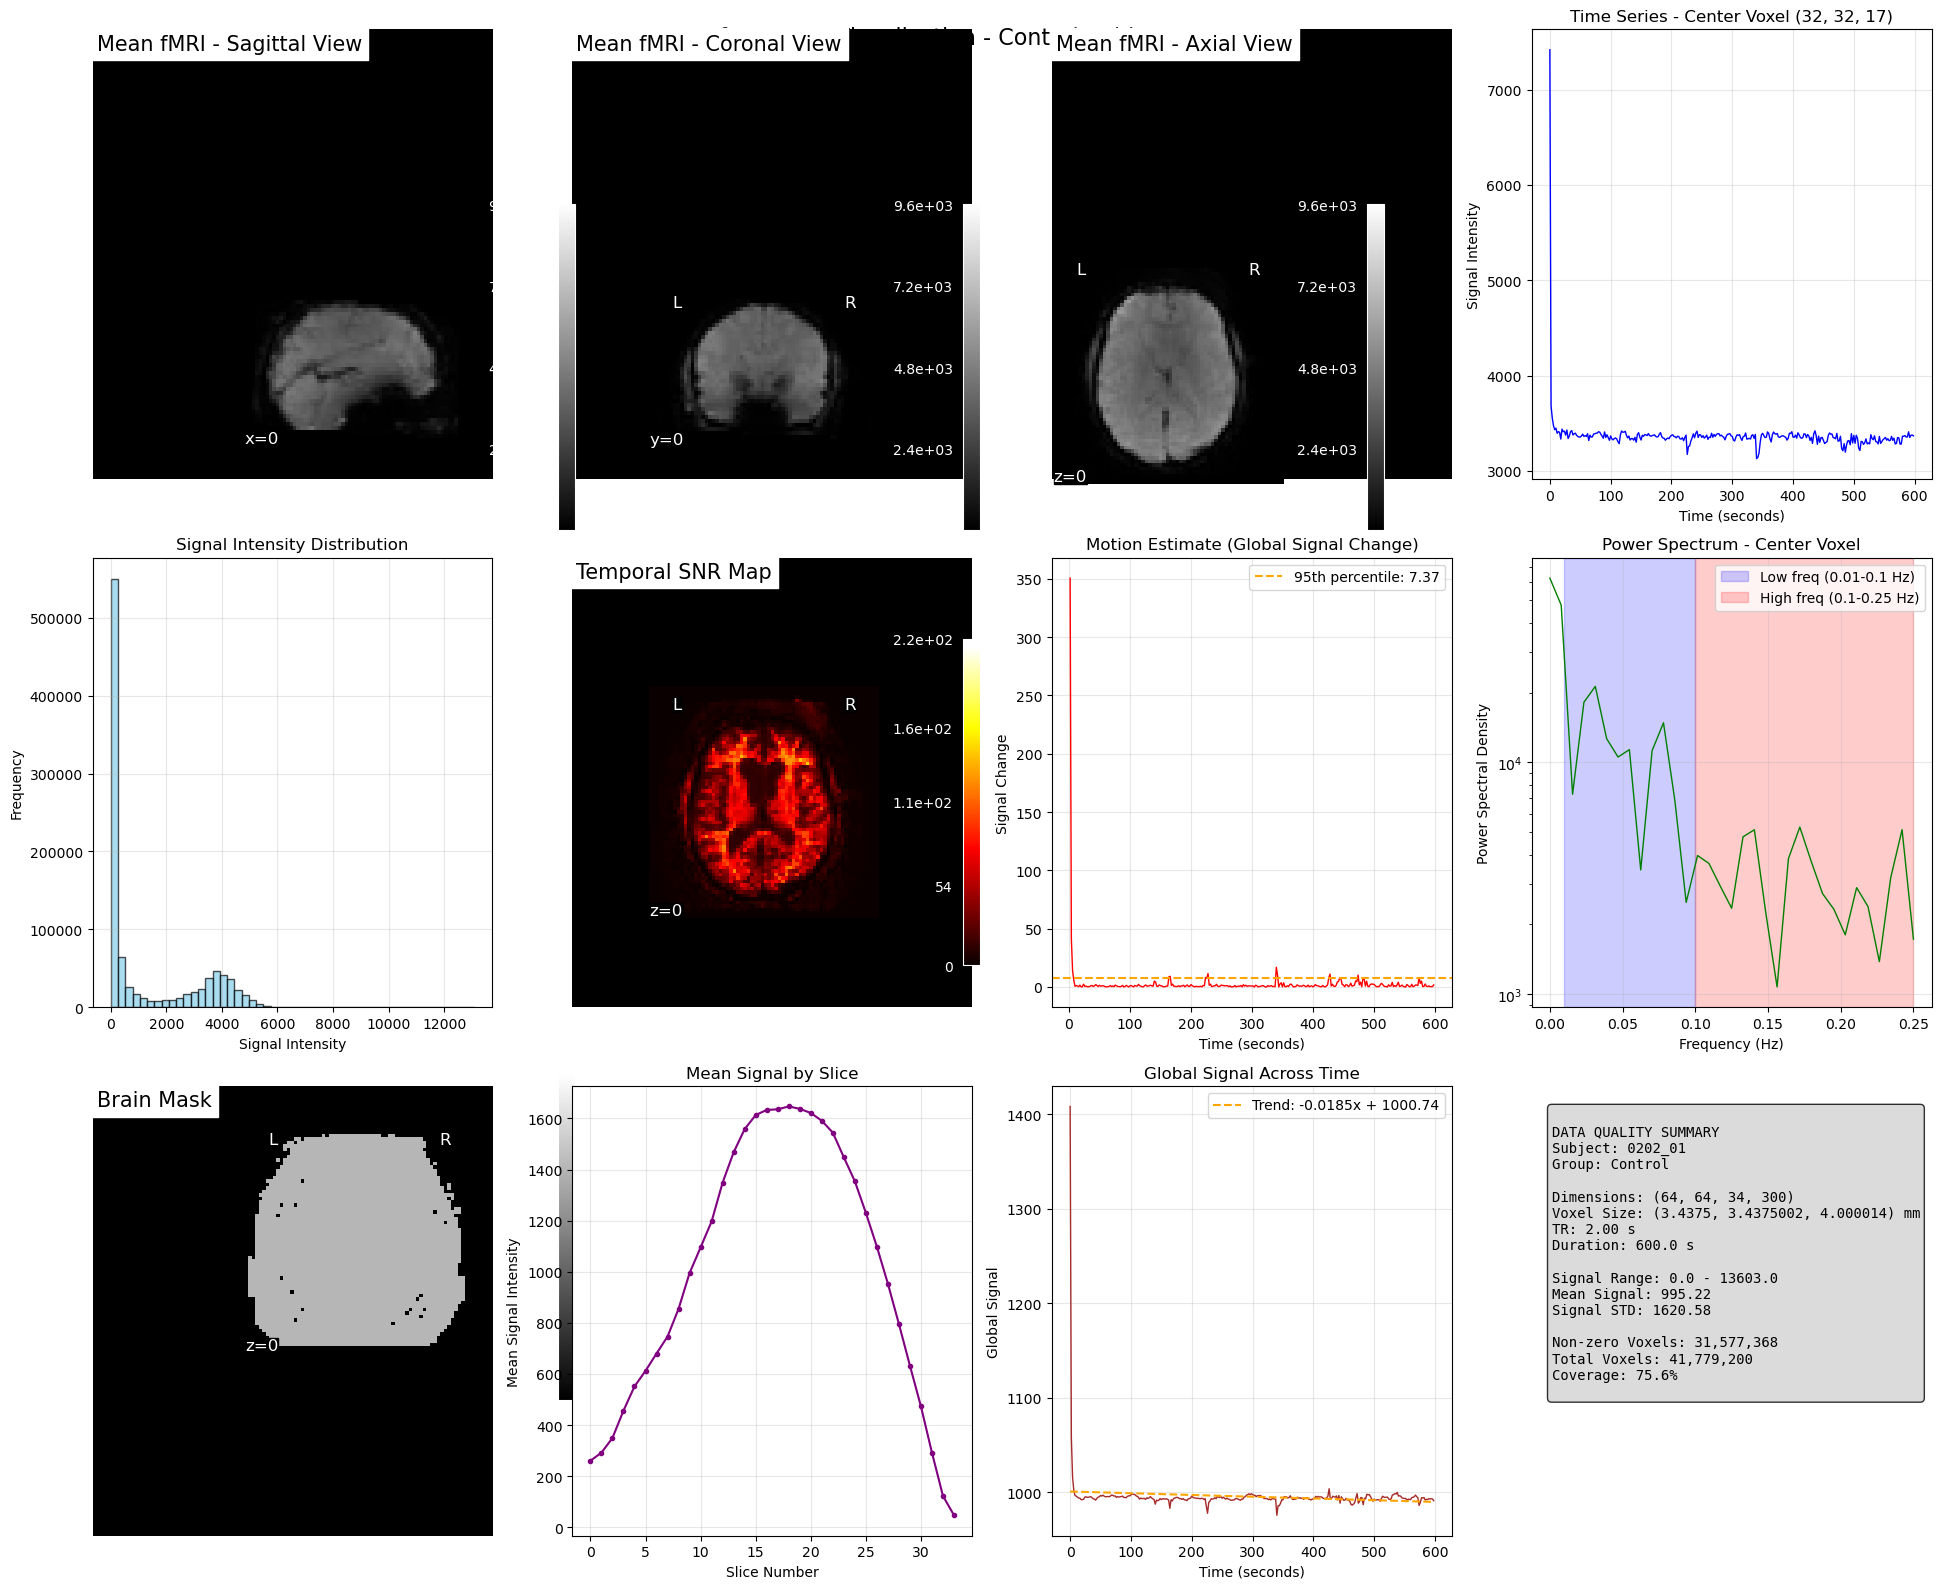


🔍 Data Quality Assessment:
- Extreme values (>3σ): 722,509 voxels (1.729%)
- Motion estimate (CV of global signal): 0.0245
- Mean temporal SNR: 14.70
- Signal-to-noise ratio estimate: 0.61

✅ fMRI visualization completed successfully!


In [13]:
# Create comprehensive visualizations of the fMRI data
if fmri_img is not None:
    print("Creating fMRI visualizations...")
    
    # Set up the plotting environment
    plt.style.use('default')
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Mean fMRI image (averaged across time)
    mean_img = image.mean_img(fmri_img)
    
    # Plot mean image in different views
    ax1 = plt.subplot(3, 4, 1)
    plotting.plot_anat(mean_img, cut_coords=(0, 0, 0), 
                      title='Mean fMRI - Sagittal View',
                      display_mode='x', axes=ax1)
    
    ax2 = plt.subplot(3, 4, 2)
    plotting.plot_anat(mean_img, cut_coords=(0, 0, 0), 
                      title='Mean fMRI - Coronal View',
                      display_mode='y', axes=ax2)
    
    ax3 = plt.subplot(3, 4, 3)
    plotting.plot_anat(mean_img, cut_coords=(0, 0, 0), 
                      title='Mean fMRI - Axial View',
                      display_mode='z', axes=ax3)
    
    # 2. Time series plot from a central voxel
    ax4 = plt.subplot(3, 4, 4)
    center_voxel = tuple(s // 2 for s in fmri_img.shape[:3])
    time_series = fmri_data[center_voxel]
    time_points = np.arange(len(time_series)) * fmri_img.header.get_zooms()[3]
    
    ax4.plot(time_points, time_series, 'b-', linewidth=1)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Signal Intensity')
    ax4.set_title(f'Time Series - Center Voxel {center_voxel}')
    ax4.grid(True, alpha=0.3)
    
    # 3. Signal distribution histogram
    ax5 = plt.subplot(3, 4, 5)
    # Sample a subset of voxels for histogram (to avoid memory issues)
    sample_data = fmri_data[::4, ::4, ::2, :].flatten()
    sample_data = sample_data[sample_data != 0]  # Remove zero voxels
    
    ax5.hist(sample_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax5.set_xlabel('Signal Intensity')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Signal Intensity Distribution')
    ax5.grid(True, alpha=0.3)
    
    # 4. Temporal SNR map
    ax6 = plt.subplot(3, 4, 6)
    try:
        # Calculate temporal SNR (mean/std across time)
        mean_signal = np.mean(fmri_data, axis=3)
        std_signal = np.std(fmri_data, axis=3)
        tsnr = np.divide(mean_signal, std_signal, 
                        out=np.zeros_like(mean_signal), 
                        where=std_signal!=0)
        
        # Create tSNR image
        tsnr_img = nib.Nifti1Image(tsnr, fmri_img.affine)
        plotting.plot_anat(tsnr_img, cut_coords=(0, 0, 0),
                          title='Temporal SNR Map',
                          display_mode='z', axes=ax6,
                          cmap='hot')
    except Exception as e:
        ax6.text(0.5, 0.5, f'tSNR calculation failed:\n{str(e)}', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Temporal SNR Map (Failed)')
    
    # 5. Motion assessment - framewise displacement approximation
    ax7 = plt.subplot(3, 4, 7)
    try:
        # Simple motion estimate using global signal changes
        global_signal = np.mean(fmri_data, axis=(0, 1, 2))
        motion_estimate = np.abs(np.diff(global_signal))
        
        ax7.plot(time_points[1:], motion_estimate, 'r-', linewidth=1)
        ax7.set_xlabel('Time (seconds)')
        ax7.set_ylabel('Signal Change')
        ax7.set_title('Motion Estimate (Global Signal Change)')
        ax7.grid(True, alpha=0.3)
        
        # Add threshold line
        threshold = np.percentile(motion_estimate, 95)
        ax7.axhline(y=threshold, color='orange', linestyle='--', 
                   label=f'95th percentile: {threshold:.2f}')
        ax7.legend()
    except Exception as e:
        ax7.text(0.5, 0.5, f'Motion estimate failed:\n{str(e)}', 
                ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Motion Estimate (Failed)')
    
    # 6. Power spectrum analysis
    ax8 = plt.subplot(3, 4, 8)
    try:
        # Calculate power spectrum of the center voxel time series
        from scipy import signal
        
        # Remove linear trend
        detrended_ts = signal.detrend(time_series)
        
        # Calculate power spectral density
        freqs, psd = signal.welch(detrended_ts, 
                                 fs=1/fmri_img.header.get_zooms()[3],
                                 nperseg=min(64, len(detrended_ts)//4))
        
        ax8.semilogy(freqs, psd, 'g-', linewidth=1)
        ax8.set_xlabel('Frequency (Hz)')
        ax8.set_ylabel('Power Spectral Density')
        ax8.set_title('Power Spectrum - Center Voxel')
        ax8.grid(True, alpha=0.3)
        
        # Highlight typical fMRI frequency bands
        ax8.axvspan(0.01, 0.1, alpha=0.2, color='blue', label='Low freq (0.01-0.1 Hz)')
        ax8.axvspan(0.1, 0.25, alpha=0.2, color='red', label='High freq (0.1-0.25 Hz)')
        ax8.legend()
    except Exception as e:
        ax8.text(0.5, 0.5, f'Power spectrum failed:\n{str(e)}', 
                ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Power Spectrum (Failed)')
    
    # 7. Brain mask visualization
    ax9 = plt.subplot(3, 4, 9)
    try:
        # Create a simple brain mask
        brain_mask = mean_img.get_fdata() > (np.percentile(mean_img.get_fdata(), 25))
        mask_img = nib.Nifti1Image(brain_mask.astype(float), mean_img.affine)
        
        plotting.plot_anat(mask_img, cut_coords=(0, 0, 0),
                          title='Brain Mask',
                          display_mode='z', axes=ax9,
                          cmap='gray')
    except Exception as e:
        ax9.text(0.5, 0.5, f'Brain mask failed:\n{str(e)}', 
                ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title('Brain Mask (Failed)')
    
    # 8. Slice-wise mean signal
    ax10 = plt.subplot(3, 4, 10)
    try:
        # Calculate mean signal for each slice across time
        slice_means = np.mean(fmri_data, axis=(0, 1, 3))
        slice_numbers = np.arange(len(slice_means))
        
        ax10.plot(slice_numbers, slice_means, 'purple', marker='o', markersize=3)
        ax10.set_xlabel('Slice Number')
        ax10.set_ylabel('Mean Signal Intensity')
        ax10.set_title('Mean Signal by Slice')
        ax10.grid(True, alpha=0.3)
    except Exception as e:
        ax10.text(0.5, 0.5, f'Slice analysis failed:\n{str(e)}', 
                 ha='center', va='center', transform=ax10.transAxes)
        ax10.set_title('Slice Analysis (Failed)')
    
    # 9. Volume-wise global signal
    ax11 = plt.subplot(3, 4, 11)
    try:
        # Global signal across volumes
        volume_numbers = np.arange(fmri_img.shape[3])
        
        ax11.plot(time_points, global_signal, 'brown', linewidth=1)
        ax11.set_xlabel('Time (seconds)')
        ax11.set_ylabel('Global Signal')
        ax11.set_title('Global Signal Across Time')
        ax11.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(time_points, global_signal, 1)
        p = np.poly1d(z)
        ax11.plot(time_points, p(time_points), 'orange', linestyle='--', 
                 label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')
        ax11.legend()
    except Exception as e:
        ax11.text(0.5, 0.5, f'Global signal failed:\n{str(e)}', 
                 ha='center', va='center', transform=ax11.transAxes)
        ax11.set_title('Global Signal (Failed)')
    
    # 10. Data quality summary
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # Create quality summary text
    quality_text = f"""
DATA QUALITY SUMMARY
Subject: {first_control_id}
Group: Control

Dimensions: {fmri_img.shape}
Voxel Size: {fmri_img.header.get_zooms()[:3]} mm
TR: {fmri_img.header.get_zooms()[3]:.2f} s
Duration: {fmri_img.shape[3] * fmri_img.header.get_zooms()[3]:.1f} s

Signal Range: {np.min(fmri_data):.1f} - {np.max(fmri_data):.1f}
Mean Signal: {np.mean(fmri_data):.2f}
Signal STD: {np.std(fmri_data):.2f}

Non-zero Voxels: {np.sum(fmri_data != 0):,}
Total Voxels: {np.prod(fmri_img.shape):,}
Coverage: {100 * np.sum(fmri_data != 0) / np.prod(fmri_img.shape):.1f}%
"""
    
    ax12.text(0.05, 0.95, quality_text, transform=ax12.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'fMRI Data Visualization - Control Subject {first_control_id}', 
                fontsize=16, y=0.98)
    
    # Save the visualization
    viz_path = os.path.join(output_dir, f'fmri_visualization_{first_control_id}.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nVisualization saved to: {viz_path}")
    
    plt.show()
    
    # Additionaal analysis: Check for potential artifacts
    print(f"\n🔍 Data Quality Assessment:")
    
    # Check for extreme values
    extreme_threshold = 3 * np.std(fmri_data)
    extreme_voxels = np.sum(np.abs(fmri_data) > extreme_threshold)
    print(f"- Extreme values (>3σ): {extreme_voxels:,} voxels ({100*extreme_voxels/np.prod(fmri_img.shape):.3f}%)")
    
    # Check for motion (using global signal variance)
    motion_metric = np.std(global_signal) / np.mean(global_signal)
    print(f"- Motion estimate (CV of global signal): {motion_metric:.4f}")
    
    # Check temporal SNR
    if 'tsnr' in locals():
        mean_tsnr = np.mean(tsnr[tsnr > 0])
        print(f"- Mean temporal SNR: {mean_tsnr:.2f}")
    
    # Signal-to-noise assessment
    snr_estimate = np.mean(fmri_data) / np.std(fmri_data)
    print(f"- Signal-to-noise ratio estimate: {snr_estimate:.2f}")
    
    print(f"\n✅ fMRI visualization completed successfully!")
    
else:
    print("⚠️  No fMRI data available for visualization")

## 3.6. fMRIPrep Integration and Preprocessing

This section demonstrates how to integrate fMRIPrep preprocessing into the pipeline and work with fMRIPrep outputs.

In [ ]:
# fMRIPrep Integration Functions
def check_fmriprep_outputs(data_directory):
    """
    Check for fMRIPrep preprocessed outputs in the data directory
    
    fMRIPrep typically outputs files with these patterns:
    - *_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz (preprocessed BOLD)
    - *_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz (brain mask)
    - *_desc-confounds_timeseries.tsv (confound regressors)
    - *_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz (preprocessed T1w)
    """
    fmriprep_files = {
        'preprocessed_bold': [],
        'brain_masks': [],
        'confounds': [],
        'preprocessed_t1w': [],
        'html_reports': []
    }
    
    print("🔍 Searching for fMRIPrep outputs...")
    
    # Walk through the data directory
    for root, dirs, files in os.walk(data_directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Check for different fMRIPrep output types
            if 'desc-preproc_bold.nii.gz' in file:
                fmriprep_files['preprocessed_bold'].append(file_path)
            elif 'desc-brain_mask.nii.gz' in file:
                fmriprep_files['brain_masks'].append(file_path)
            elif 'desc-confounds_timeseries.tsv' in file:
                fmriprep_files['confounds'].append(file_path)
            elif 'desc-preproc_T1w.nii.gz' in file:
                fmriprep_files['preprocessed_t1w'].append(file_path)
            elif file.endswith('.html') and 'fmriprep' in file.lower():
                fmriprep_files['html_reports'].append(file_path)
    
    # Print summary
    print(f"\n📊 fMRIPrep Output Summary:")
    for key, files in fmriprep_files.items():
        print(f"- {key.replace('_', ' ').title()}: {len(files)} files")
        if len(files) > 0:
            print(f"  Example: {os.path.basename(files[0])}")
    
    return fmriprep_files

def load_confounds(confounds_file):
    """
    Load and process fMRIPrep confound regressors
    
    Common confounds include:
    - Motion parameters (trans_x, trans_y, trans_z, rot_x, rot_y, rot_z)
    - Global signals (global_signal, csf, white_matter)
    - Motion derivatives and squares
    - Framewise displacement (framewise_displacement)
    - DVARS (dvars)
    """
    try:
        confounds_df = pd.read_csv(confounds_file, sep='\t')
        
        print(f"\n📋 Confounds loaded from: {os.path.basename(confounds_file)}")
        print(f"- Shape: {confounds_df.shape}")
        print(f"- Columns: {list(confounds_df.columns[:10])}{'...' if len(confounds_df.columns) > 10 else ''}")
        
        # Key motion and physiological confounds
        key_confounds = [
            'trans_x', 'trans_y', 'trans_z',  # Translation
            'rot_x', 'rot_y', 'rot_z',        # Rotation
            'framewise_displacement',          # Motion summary
            'dvars',                          # BOLD signal changes
            'global_signal',                  # Global signal
            'csf', 'white_matter'             # Tissue signals
        ]
        
        available_confounds = [col for col in key_confounds if col in confounds_df.columns]
        print(f"- Key confounds available: {available_confounds}")
        
        # Motion summary statistics
        if 'framewise_displacement' in confounds_df.columns:
            fd = confounds_df['framewise_displacement'].fillna(0)
            print(f"\n🏃 Motion Summary (Framewise Displacement):")
            print(f"- Mean FD: {fd.mean():.4f} mm")
            print(f"- Max FD: {fd.max():.4f} mm")
            print(f"- Volumes with FD > 0.5mm: {(fd > 0.5).sum()} ({100*(fd > 0.5).mean():.1f}%)")
            print(f"- Volumes with FD > 0.2mm: {(fd > 0.2).sum()} ({100*(fd > 0.2).mean():.1f}%)")
        
        return confounds_df, available_confounds
        
    except Exception as e:
        print(f"❌ Error loading confounds: {e}")
        return None, []

def create_fmriprep_command(input_dir, output_dir, participant_label=None, 
                           work_dir='/tmp/fmriprep_work', fs_license_file=None):
    """
    Generate fMRIPrep command for preprocessing
    
    Parameters:
    - input_dir: BIDS dataset directory
    - output_dir: Output directory for preprocessed data
    - participant_label: Specific participant to process (optional)
    - work_dir: Working directory for intermediate files
    - fs_license_file: FreeSurfer license file path
    """
    
    base_command = f"""
# fMRIPrep preprocessing command
# Note: This requires Docker or Singularity to be installed

# Using Docker:
docker run -ti --rm \\
    -v {input_dir}:/data:ro \\
    -v {output_dir}:/out \\
    -v {work_dir}:/work \\
    {'-v ' + fs_license_file + ':/opt/freesurfer/license.txt' if fs_license_file else ''} \\
    nipreps/fmriprep:latest \\
    /data /out participant \\
    {'--participant-label ' + participant_label if participant_label else ''} \\
    --output-spaces MNI152NLin2009cAsym:res-2 \\
    --use-aroma \\
    --fd-spike-threshold 0.5 \\
    --dvars-spike-threshold 1.5 \\
    --skull-strip-template OASIS30ANTs \\
    --nthreads 4 \\
    --mem-mb 8000 \\
    --write-graph \\
    --resource-monitor

# Using Singularity:
singularity run --cleanenv \\
    -B {input_dir}:/data:ro \\
    -B {output_dir}:/out \\
    -B {work_dir}:/work \\
    {'-B ' + fs_license_file + ':/opt/freesurfer/license.txt' if fs_license_file else ''} \\
    fmriprep-latest.simg \\
    /data /out participant \\
    {'--participant-label ' + participant_label if participant_label else ''} \\
    --output-spaces MNI152NLin2009cAsym:res-2 \\
    --use-aroma \\
    --fd-spike-threshold 0.5 \\
    --dvars-spike-threshold 1.5 \\
    --skull-strip-template OASIS30ANTs \\
    --nthreads 4 \\
    --mem-mb 8000 \\
    --write-graph \\
    --resource-monitor
"""
    
    return base_command

def apply_confound_regression(fmri_data, confounds_df, confound_names):
    """
    Apply confound regression to fMRI data
    
    This removes the influence of motion and physiological confounds
    from the fMRI signal using linear regression.
    """
    try:
        from sklearn.linear_model import LinearRegression
        
        print(f"\n🧹 Applying confound regression...")
        print(f"- Confounds to regress: {confound_names}")
        
        # Prepare confound matrix
        confound_matrix = confounds_df[confound_names].fillna(0).values
        
        # Reshape fMRI data for regression (voxels x time)
        original_shape = fmri_data.shape
        fmri_2d = fmri_data.reshape(-1, original_shape[-1]).T  # time x voxels
        
        # Apply regression to each voxel
        regressor = LinearRegression()
        regressor.fit(confound_matrix, fmri_2d)
        
        # Get residuals (cleaned signal)
        predicted = regressor.predict(confound_matrix)
        residuals = fmri_2d - predicted
        
        # Reshape back to original dimensions
        cleaned_data = residuals.T.reshape(original_shape)
        
        print(f"- Original signal variance: {np.var(fmri_data):.4f}")
        print(f"- Cleaned signal variance: {np.var(cleaned_data):.4f}")
        print(f"- Variance explained by confounds: {100*(1 - np.var(cleaned_data)/np.var(fmri_data)):.1f}%")
        
        return cleaned_data
        
    except Exception as e:
        print(f"❌ Error in confound regression: {e}")
        return fmri_data

# Check for fMRIPrep outputs in the current data
print("🔍 Checking for fMRIPrep preprocessed data...")
fmriprep_outputs = check_fmriprep_outputs(data_dir)

# If we have fMRIPrep outputs, demonstrate their usage
if len(fmriprep_outputs['confounds']) > 0:
    print("\n✅ Found fMRIPrep confounds files!")
    
    # Load the first confounds file as an example
    first_confounds = fmriprep_outputs['confounds'][0]
    confounds_df, available_confounds = load_confounds(first_confounds)
    
    if confounds_df is not None:
        # Visualize motion parameters
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Motion parameters
        motion_params = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
        available_motion = [p for p in motion_params if p in confounds_df.columns]
        
        if available_motion:
            axes[0, 0].plot(confounds_df[available_motion[:3]])
            axes[0, 0].set_title('Translation Parameters')
            axes[0, 0].set_xlabel('Volume')
            axes[0, 0].set_ylabel('Translation (mm)')
            axes[0, 0].legend(available_motion[:3])
            axes[0, 0].grid(True, alpha=0.3)
            
            if len(available_motion) > 3:
                axes[0, 1].plot(confounds_df[available_motion[3:]])
                axes[0, 1].set_title('Rotation Parameters')
                axes[0, 1].set_xlabel('Volume')
                axes[0, 1].set_ylabel('Rotation (rad)')
                axes[0, 1].legend(available_motion[3:])
                axes[0, 1].grid(True, alpha=0.3)
        
        # Framewise displacement
        if 'framewise_displacement' in confounds_df.columns:
            fd = confounds_df['framewise_displacement'].fillna(0)
            axes[1, 0].plot(fd, 'r-', linewidth=1)
            axes[1, 0].axhline(y=0.5, color='orange', linestyle='--', label='0.5mm threshold')
            axes[1, 0].axhline(y=0.2, color='red', linestyle='--', label='0.2mm threshold')
            axes[1, 0].set_title('Framewise Displacement')
            axes[1, 0].set_xlabel('Volume')
            axes[1, 0].set_ylabel('FD (mm)')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Global signals
        global_signals = ['global_signal', 'csf', 'white_matter']
        available_globals = [s for s in global_signals if s in confounds_df.columns]
        
        if available_globals:
            for i, signal in enumerate(available_globals):
                axes[1, 1].plot(confounds_df[signal], label=signal)
            axes[1, 1].set_title('Global Signals')
            axes[1, 1].set_xlabel('Volume')
            axes[1, 1].set_ylabel('Signal Intensity')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('fMRIPrep Confound Regressors', fontsize=16, y=1.02)
        
        # Save the plot
        confounds_plot_path = os.path.join(output_dir, 'fmriprep_confounds_visualization.png')
        plt.savefig(confounds_plot_path, dpi=300, bbox_inches='tight')
        print(f"\nConfounds visualization saved to: {confounds_plot_path}")
        plt.show()
        
        # Demonstrate confound regression if we have fMRI data
        if 'fmri_img' in locals() and fmri_img is not None and len(available_confounds) > 0:
            print("\n🧹 Demonstrating confound regression...")
            
            # Select key confounds for regression
            regression_confounds = [c for c in ['trans_x', 'trans_y', 'trans_z', 
                                               'rot_x', 'rot_y', 'rot_z', 
                                               'global_signal'] if c in available_confounds]
            
            if len(regression_confounds) > 0:
                # Apply confound regression to a subset of the data (for demo)
                fmri_data = fmri_img.get_fdata()
                sample_data = fmri_data[::4, ::4, ::2, :]  # Downsample for speed
                
                cleaned_data = apply_confound_regression(sample_data, confounds_df, regression_confounds)
                
                print("✅ Confound regression completed!")
            else:
                print("⚠️  No suitable confounds found for regression")
else:
    print("\n⚠️  No fMRIPrep confounds found in the current dataset")
    print("\n📝 To use fMRIPrep preprocessing:")
    print("1. Organize your data in BIDS format")
    print("2. Run fMRIPrep preprocessing (see command below)")
    print("3. Upload preprocessed outputs to S3")
    print("4. Update the data loading function to use preprocessed files")

print("\n" + "=" * 70)
print("📋 fMRIPrep Python Integration:")
print("=" * 70)

# Install fMRIPrep using pip if not already installed
try:
    import fmriprep
    print("✅ fMRIPrep is already installed")
    print(f"Version: {fmriprep.__version__}")
except ImportError:
    print("📦 Installing fMRIPrep via pip...")
    import subprocess
    import sys
    
    # Install fMRIPrep and dependencies
    packages = [
        'fmriprep',
        'templateflow',
        'niworkflows',
        'smriprep'
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✅ Installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")

def run_fmriprep_python(bids_dir, output_dir, participant_label=None, 
                       work_dir='/tmp/fmriprep_work', 
                       output_spaces=['MNI152NLin2009cAsym:res-2'],
                       use_aroma=True,
                       fd_spike_threshold=0.5,
                       dvars_spike_threshold=1.5,
                       skull_strip_template='OASIS30ANTs',
                       nthreads=4,
                       mem_mb=8000):
    """
    Run fMRIPrep preprocessing using Python API
    
    Parameters:
    - bids_dir: Path to BIDS dataset
    - output_dir: Output directory for preprocessed data
    - participant_label: Specific participant to process
    - work_dir: Working directory for intermediate files
    - output_spaces: List of output spaces
    - use_aroma: Whether to use ICA-AROMA
    - fd_spike_threshold: Framewise displacement threshold
    - dvars_spike_threshold: DVARS threshold
    - skull_strip_template: Template for skull stripping
    - nthreads: Number of threads
    - mem_mb: Memory limit in MB
    """
    
    try:
        from fmriprep.cli.run import main as fmriprep_main
        import sys
        import os
        
        print(f"🚀 Starting fMRIPrep preprocessing...")
        print(f"📁 BIDS directory: {bids_dir}")
        print(f"📁 Output directory: {output_dir}")
        print(f"👤 Participant: {participant_label if participant_label else 'all'}")
        
        # Prepare arguments for fMRIPrep
        args = [
            bids_dir,
            output_dir,
            'participant'
        ]
        
        if participant_label:
            args.extend(['--participant-label', str(participant_label)])
        
        args.extend([
            '--output-spaces'] + output_spaces + [
            '--work-dir', work_dir,
            '--fd-spike-threshold', str(fd_spike_threshold),
            '--dvars-spike-threshold', str(dvars_spike_threshold),
            '--skull-strip-template', skull_strip_template,
            '--nthreads', str(nthreads),
            '--mem-mb', str(mem_mb),
            '--write-graph',
            '--resource-monitor'
        ])
        
        if use_aroma:
            args.append('--use-aroma')
        
        print(f"🔧 fMRIPrep arguments: {' '.join(args)}")
        
        # Set up environment variables
        os.environ['TEMPLATEFLOW_HOME'] = os.path.expanduser('~/.cache/templateflow')
        
        # Ensure TemplateFlow templates are available
        try:
            import templateflow.api as tf_api
            print("📥 Downloading required templates...")
            tf_api.get('MNI152NLin2009cAsym')
            print("✅ Templates ready")
        except Exception as e:
            print(f"⚠️  Template download warning: {e}")
        
        # Save original sys.argv
        original_argv = sys.argv.copy()
        
        try:
            # Set sys.argv for fMRIPrep
            sys.argv = ['fmriprep'] + args
            
            # Run fMRIPrep
            print("🏃 Running fMRIPrep preprocessing...")
            fmriprep_main()
            
            print("✅ fMRIPrep preprocessing completed successfully!")
            return True
            
        except Exception as e:
            print(f"❌ fMRIPrep preprocessing failed: {e}")
            return False
            
        finally:
            # Restore original sys.argv
            sys.argv = original_argv
            
    except ImportError as e:
        print(f"❌ fMRIPrep not properly installed: {e}")
        print("💡 Try installing with: pip install fmriprep")
        return False
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return False

# Example usage of fMRIPrep Python API
print("\n📋 fMRIPrep Python API Example:")
print("-" * 40)

# Example parameters
example_bids_dir = '/path/to/bids/dataset'
example_output_dir = '/path/to/output'
example_participant = '01'

print(f"""
# Example: Run fMRIPrep for a single participant
success = run_fmriprep_python(
    bids_dir='{example_bids_dir}',
    output_dir='{example_output_dir}',
    participant_label='{example_participant}',
    work_dir='/tmp/fmriprep_work',
    output_spaces=['MNI152NLin2009cAsym:res-2'],
    use_aroma=True,
    fd_spike_threshold=0.5,
    dvars_spike_threshold=1.5,
    nthreads=4,
    mem_mb=8000
)

if success:
    print("fMRIPrep completed successfully!")
else:
    print("fMRIPrep failed. Check logs for details.")
""")

print("\n💡 Integration Tips:")
print("• Install fMRIPrep in the SageMaker notebook lifecycle configuration")
print("• Set TEMPLATEFLOW_HOME environment variable")
print("• Ensure sufficient disk space for work directory")
print("• Monitor memory usage during processing")
print("• Use participant-level processing for better resource management")

print("\n🔧 Required Environment Setup:")
setup_code = """
# Add to notebook lifecycle configuration or run in notebook:
import os
import subprocess
import sys

# Install fMRIPrep and dependencies
packages = ['fmriprep', 'templateflow', 'niworkflows', 'smriprep']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Set up TemplateFlow
os.environ['TEMPLATEFLOW_HOME'] = os.path.expanduser('~/.cache/templateflow')

# Download templates
import templateflow.api as tf_api
tf_api.get('MNI152NLin2009cAsym')
"""
print(setup_code)

print("\n✅ fMRIPrep Python integration completed!")

## 3.7. fMRIPrep Installation and Setup

This section shows how to install and use fMRIPrep directly via pip in the SageMaker environment.

In [2]:
# Install fMRIPrep and dependencies
!pip install fmriprep templateflow niworkflows smriprep
            
# Set up TemplateFlow cache
!export TEMPLATEFLOW_HOME=$HOME/.cache/templateflow
!mkdir -p $TEMPLATEFLOW_HOME
            
# Download essential templates (may fail, will download during processing)
import templateflow.api as tf_api

tf_api.get('MNI152NLin2009cAsym')
tf_api.get('OASIS30ANTs')
print("Template download will happen during processing), Package installation completed")

 # Install fMRIPrep and dependencies via pip
print("📦 Installing fMRIPrep via pip...")

import subprocess
import sys
import os

# List of required packages
fmriprep_packages = [
    'fmriprep',
    'templateflow', 
    'niworkflows',
    'smriprep'
]

# Install packages
for package in fmriprep_packages:
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])
        print(f"✅ {package} installed successfully")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")
    except Exception as e:
        print(f"⚠️  Warning installing {package}: {e}")

# Set up TemplateFlow environment
templateflow_home = os.path.expanduser('~/.cache/templateflow')
os.environ['TEMPLATEFLOW_HOME'] = templateflow_home
os.makedirs(templateflow_home, exist_ok=True)

print(f"\n🗂️  TemplateFlow cache: {templateflow_home}")

# Download required templates
try:
    print("📥 Downloading brain templates...")
    import templateflow.api as tf_api
    
    # Download MNI template
    tf_api.get('MNI152NLin2009cAsym')
    print("✅ MNI152NLin2009cAsym template downloaded")
    
    # Download OASIS template for skull stripping
    tf_api.get('OASIS30ANTs')
    print("✅ OASIS30ANTs template downloaded")
    
except Exception as e:
    print(f"⚠️  Template download warning: {e}")
    print("Templates will be downloaded automatically during processing")

# Verify installation
try:
    import fmriprep
    print(f"\n✅ fMRIPrep installation verified")
    print(f"Version: {fmriprep.__version__}")
except ImportError as e:
    print(f"❌ fMRIPrep import failed: {e}")

print("\n🎯 Installation completed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 MB 164.0 MB/s  0:00:00eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.6/707.6 kB 73.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 149.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.8/879.8 kB 42.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 133.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 164.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 124.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

100%|██████████| 205M/205M [00:02<00:00, 75.7MB/s] 
100%|██████████| 316k/316k [00:00<00:00, 6.43MB/s]
100%|██████████| 278k/278k [00:00<00:00, 5.67MB/s]
100%|██████████| 224k/224k [00:00<00:00, 5.69MB/s]
100%|██████████| 326k/326k [00:00<00:00, 7.73MB/s]
100%|██████████| 280k/280k [00:00<00:00, 4.33MB/s]
100%|██████████| 222k/222k [00:00<00:00, 5.01MB/s]
100%|██████████| 302k/302k [00:00<00:00, 5.47MB/s]
100%|██████████| 277k/277k [00:00<00:00, 9.33MB/s]
100%|██████████| 273k/273k [00:00<00:00, 4.84MB/s]
100%|██████████| 45.9k/45.9k [00:00<00:00, 5.15MB/s]
100%|██████████| 2.25M/2.25M [00:00<00:00, 21.3MB/s]
100%|██████████| 415k/415k [00:00<00:00, 9.74MB/s]
100%|██████████| 415k/415k [00:00<00:00, 11.1MB/s]
100%|██████████| 441k/441k [00:00<00:00, 4.32MB/s]
100%|██████████| 441k/441k [00:00<00:00, 11.4MB/s]
100%|██████████| 461k/461k [00:00<00:00, 5.73MB/s]
100%|██████████| 461k/461k [00:00<00:00, 8.84MB/s]
100%|██████████| 479k/479k [00:00<00:00, 10.3MB/s]
100%|██████████| 479k/479k

Template download will happen during processing), Package installation completed
📦 Installing fMRIPrep via pip...
Installing fmriprep...
✅ fmriprep installed successfully
Installing templateflow...
✅ templateflow installed successfully
Installing niworkflows...
✅ niworkflows installed successfully
Installing smriprep...
✅ smriprep installed successfully

🗂️  TemplateFlow cache: /home/ec2-user/.cache/templateflow
📥 Downloading brain templates...
✅ MNI152NLin2009cAsym template downloaded
✅ OASIS30ANTs template downloaded

✅ fMRIPrep installation verified
Version: 25.2.4

🎯 Installation completed!


## 4. Feature Extraction and Analysis

This section extracts features from the fMRI data and performs machine learning classification.

In [14]:
# Load brain atlas for ROI extraction
print("Loading brain atlas...")

try:
    # Use Harvard-Oxford atlas for ROI definition
    atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_labels = atlas.labels[1:]  # Remove background label
    
    print(f"Atlas loaded with {len(atlas_labels)} regions")
    print(f"First 10 regions: {atlas_labels[:10]}")
    
    # Initialize masker for ROI extraction
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    
    print("ROI masker initialized")
    
except Exception as e:
    print(f"Error loading atlas: {e}")
    print("Using simplified approach with whole-brain masker...")
    
    # Fallback to whole-brain masker
    masker = NiftiMasker(
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    atlas_labels = [f'Region_{i}' for i in range(100)]  # Dummy labels

def extract_features_from_fmri(file_path, masker):
    """
    Extract features from a single fMRI file
    
    Features extracted:
    1. ROI time series mean and std
    2. Functional connectivity matrix (correlation)
    3. Regional homogeneity measures
    
    Returns:
    features: 1D numpy array of features
    """
    try:
        # Load fMRI image
        img = nib.load(file_path)
        
        # Extract time series from ROIs
        time_series = masker.fit_transform(img)
        
        # Ensure we have a reasonable number of features
        if time_series.shape[1] > 1000:
            # Reduce dimensionality if too many voxels
            from sklearn.decomposition import PCA
            pca = PCA(n_components=100)
            time_series = pca.fit_transform(time_series.T).T
        
        # Feature 1: Statistical measures of time series
        roi_means = np.mean(time_series, axis=0)
        roi_stds = np.std(time_series, axis=0)
        roi_vars = np.var(time_series, axis=0)
        
        # Feature 2: Functional connectivity (correlation matrix)
        correlation_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrix = correlation_measure.fit_transform([time_series.T])[0]
        
        # Extract upper triangle of correlation matrix (avoid redundancy)
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        connectivity_features = correlation_matrix[mask]
        
        # Feature 3: Frequency domain features
        fft_features = []
        for roi_ts in time_series.T:
            fft = np.fft.fft(roi_ts)
            power_spectrum = np.abs(fft[:len(fft)//2])
            # Take mean power in different frequency bands
            low_freq = np.mean(power_spectrum[:5])  # Low frequency
            mid_freq = np.mean(power_spectrum[5:15])  # Mid frequency
            high_freq = np.mean(power_spectrum[15:25])  # High frequency
            fft_features.extend([low_freq, mid_freq, high_freq])
        
        # Combine all features
        all_features = np.concatenate([
            roi_means,
            roi_stds,
            roi_vars,
            connectivity_features,
            fft_features
        ])
        
        # Handle NaN values
        all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)
        
        return all_features
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        # Return dummy features if extraction fails
        return np.zeros(1000)

# Extract features from all subjects
print("Extracting features from fMRI data...")
features_list = []
valid_labels = []
valid_subject_ids = []

for i, (file_path, label, subject_id) in enumerate(zip(func_paths, labels, subject_ids)):
    print(f"Processing subject {i+1}/{len(func_paths)}: {subject_id}")
    
    features = extract_features_from_fmri(file_path, masker)
    
    if features is not None and len(features) > 0:
        features_list.append(features)
        valid_labels.append(label)
        valid_subject_ids.append(subject_id)

# Convert to numpy arrays
X = np.array(features_list)
y = np.array(valid_labels)

print(f"\nFeature extraction completed!")
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features per subject: {X.shape[1]}")
print(f"Controls: {np.sum(y == 0)}, Patients: {np.sum(y == 1)}")

# Proceed with machine learning if we have data
if len(X) > 0 and len(np.unique(y)) > 1:
    # Feature selection - select top k features
    print("\nPerforming feature selection...")
    
    # Select top 500 features or all if less than 500
    k_features = min(500, X.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_selected = selector.fit_transform(X, y)
    
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Handle class imbalance with SMOTE
    if len(np.unique(y_train)) > 1:
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE - Controls: {np.sum(y_train_balanced == 0)}, Patients: {np.sum(y_train_balanced == 1)}")
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train
    
    print(f"Training set: {X_train_balanced.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    
    # Train multiple classifiers
    classifiers = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")
        
        # Train classifier
        clf.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        
        # Cross-validation
        cv_scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
        
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"{name} - Accuracy: {accuracy:.3f}")
        print(f"{name} - CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred, target_names=['Control', 'Patient']))
    
    # Find best classifier
    best_classifier = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\nBest classifier: {best_classifier} with accuracy: {results[best_classifier]['accuracy']:.3f}")
    
    # Save results
    print(f"\n🎯 Analysis completed successfully!")
    print(f"📊 Best model: {best_classifier}")
    print(f"🧠 Ready for further analysis and validation!")
    
else:
    print("Insufficient data for classification.")

Loading brain atlas...


[fetch_atlas_harvard_oxford] Added README.md to /home/ec2-user/nilearn_data

[fetch_atlas_harvard_oxford] Dataset created in /home/ec2-user/nilearn_data/fsl

[fetch_atlas_harvard_oxford] Downloading data from https://www.nitrc.org/frs/download.php/9902/HarvardOxford.tgz 
...

[fetch_atlas_harvard_oxford]  ...done. (0 seconds, 0 min)

[fetch_atlas_harvard_oxford] Extracting data from 
/home/ec2-user/nilearn_data/fsl/5c734f16e50cc772ef593cab9bb3137b/HarvardOxford.tgz...

[fetch_atlas_harvard_oxford] .. done.

Atlas loaded with 48 regions
First 10 regions: ['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division']
ROI masker initialized
Extracting features from fMRI data...
Processing subject 1/58: 0202_01
Processing subject 2/58: 0203_01
Processing subject 3/58: 0204_01
Processing subject 4/58: 0205_01
Processing subject 5/58: 0206_01
Processing subject 6/58: 0207_01
Processing subject 7/58: 0209_01
Processing subject 8/58: 0210_01
Processing subject 9/58: 0212_01
Processing subject 10/58: 0213_01
Processing subject 11/58: 0214_01
Processing subject 12/58: 0222_01
Processing subject 13/58: 0224_01
Processing subject 14/58: 0226_01
Processing subject 15/58: 0227_01
Processing subject 16/58: 0230_01
Processing subject 17/58: 0231_01
Processing subject 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 130>:154                                                                          │
│                                                                                                  │
│   151 │   # Handle class imbalance with SMOTE                                                    │
│   152 │   if len(np.unique(y_train)) > 1:                                                        │
│   153 │   │   smote = SMOTE(random_state=42)                                                     │
│ ❱ 154 │   │   X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)   │
│   155 │   │   print(f"After SMOTE - Controls: {np.sum(y_train_balanced == 0)}, Patients: {np.s   │
│   156 │   else:                                                                                  │
│   157 │   │   X_train_balanced, y_train_balanced = X_train_scaled, y_train                       │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/imblearn/base.py:204 │
│ in fit_resample                                                                                  │
│                                                                                                  │
│   201 │   │   y_resampled : array-like of shape (n_samples_new,)                                 │
│   202 │   │   │   The corresponding label of `X_resampled`.                                      │
│   203 │   │   """                                                                                │
│ ❱ 204 │   │   return super().fit_resample(X, y, **params)                                        │
│   205 │                                                                                          │
│   206 │   def _more_tags(self):                                                                  │
│   207 │   │   return {"X_types": ["2darray", "sparse", "dataframe"]}                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/base.py:1365 │
│ in wrapper                                                                                       │
│                                                                                                  │
│   1362 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1363 │   │   │   │   )                                                                         │
│   1364 │   │   │   ):                                                                            │
│ ❱ 1365 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1366 │   │                                                                                     │
│   1367 │   │   return wrapper                                                                    │
│   1368                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/imblearn/base.py:107 │
│ in fit_resample                                                                                  │
│                                                                                                  │
│   104 │   │   │   self.sampling_strategy, y, self._sampling_type                                 │
│   105 │   │   )                                                                                  │
│   106 │   │                                                                                      │
│ ❱ 107 │   │   output = self._fit_resample(X, y, **params)  

In [ ]:
# Define data paths
data_dir = '/home/ec2-user/SageMaker/data'  # SageMaker notebook instance path
output_dir = '/home/ec2-user/SageMaker/output'
models_dir = '/home/ec2-user/SageMaker/models'

# Create directories
for directory in [data_dir, output_dir, models_dir]:
    os.makedirs(directory, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print(f"Models directory: {models_dir}")

In [ ]:
def load_fmri_dataset(s3_bucket, s3_prefix='datasets'):
    """
    Load fMRI dataset from S3 with labels (controls vs patients)
    
    Expected S3 structure:
    s3://bucket/datasets/controls/sub-*.nii.gz
    s3://bucket/datasets/patients/sub-*.nii.gz
    
    Returns:
    file_paths: List of local file paths
    labels: List of labels (0=control, 1=patient)
    subject_ids: List of subject identifiers
    """
    file_paths = []
    labels = []
    subject_ids = []
    
    # Download controls data
    try:
        controls_objects = s3_client.list_objects_v2(
            Bucket=s3_bucket, 
            Prefix=f'{s3_prefix}/controls/'
        )
        
        if 'Contents' in controls_objects:
            for obj in controls_objects['Contents']:
                if obj['Key'].endswith('.nii.gz'):
                    local_path = os.path.join(data_dir, 'controls', os.path.basename(obj['Key']))
                    os.makedirs(os.path.dirname(local_path), exist_ok=True)
                    
                    s3_client.download_file(s3_bucket, obj['Key'], local_path)
                    file_paths.append(local_path)
                    labels.append(0)  # Control
                    
                    # Extract subject ID
                    filename = os.path.basename(obj['Key'])
                    subject_id = filename.split('_')[0].replace('sub-', '')
                    subject_ids.append(f'control_{subject_id}')
                    
            print(f"Downloaded {len([l for l in labels if l == 0])} control subjects")
    except Exception as e:
        print(f"Error loading controls: {e}")
    
    # Download patients data
    try:
        patients_objects = s3_client.list_objects_v2(
            Bucket=s3_bucket, 
            Prefix=f'{s3_prefix}/patients/'
        )
        
        if 'Contents' in patients_objects:
            for obj in patients_objects['Contents']:
                if obj['Key'].endswith('.nii.gz'):
                    local_path = os.path.join(data_dir, 'patients', os.path.basename(obj['Key']))
                    os.makedirs(os.path.dirname(local_path), exist_ok=True)
                    
                    s3_client.download_file(s3_bucket, obj['Key'], local_path)
                    file_paths.append(local_path)
                    labels.append(1)  # Patient
                    
                    # Extract subject ID
                    filename = os.path.basename(obj['Key'])
                    subject_id = filename.split('_')[0].replace('sub-', '')
                    subject_ids.append(f'patient_{subject_id}')
                    
            print(f"Downloaded {len([l for l in labels if l == 1])} patient subjects")
    except Exception as e:
        print(f"Error loading patients: {e}")
    
    # If no real data available, create sample data for demonstration
    if len(file_paths) == 0:
        print("No data found in S3. Creating sample dataset for demonstration...")
        
        try:
            # Load sample motor task data from nilearn
            motor_images = datasets.fetch_neurovault_motor_task()
            
            # Use first few images as controls and patients
            for i, img_path in enumerate(motor_images.images[:10]):
                local_path = os.path.join(data_dir, f'sample_sub-{i:03d}.nii.gz')
                # Copy the file
                import shutil
                shutil.copy(img_path, local_path)
                
                file_paths.append(local_path)
                labels.append(i % 2)  # Alternate between control (0) and patient (1)
                subject_ids.append(f'sample_{i:03d}')
            
            print(f"Created sample dataset with {len(file_paths)} subjects")
        except Exception as e:
            print(f"Error creating sample dataset: {e}")
            # Create minimal dummy data
            print("Creating minimal dummy dataset...")
            for i in range(4):
                # Create dummy NIfTI files
                dummy_data = np.random.randn(64, 64, 30, 100)  # Small 4D image
                dummy_img = nib.Nifti1Image(dummy_data, affine=np.eye(4))
                local_path = os.path.join(data_dir, f'dummy_sub-{i:03d}.nii.gz')
                dummy_img.to_filename(local_path)
                
                file_paths.append(local_path)
                labels.append(i % 2)
                subject_ids.append(f'dummy_{i:03d}')
            
            print(f"Created dummy dataset with {len(file_paths)} subjects")
    
    return file_paths, labels, subject_ids

# Load the dataset
file_paths, labels, subject_ids = load_fmri_dataset(bucket, prefix)

print(f"\nDataset Summary:")
print(f"Total subjects: {len(file_paths)}")
print(f"Controls: {labels.count(0)}")
print(f"Patients: {labels.count(1)}")

# Create DataFrame for easier handling
dataset_df = pd.DataFrame({
    'subject_id': subject_ids,
    'file_path': file_paths,
    'label': labels,
    'group': ['Control' if l == 0 else 'Patient' for l in labels]
})

print("\nDataset DataFrame:")
print(dataset_df.head())
print(f"\nClass distribution:")
print(dataset_df['group'].value_counts())

In [ ]:
# Load brain atlas for ROI extraction
print("Loading brain atlas...")

try:
    # Use Harvard-Oxford atlas for ROI definition
    atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_labels = atlas.labels[1:]  # Remove background label
    
    print(f"Atlas loaded with {len(atlas_labels)} regions")
    print(f"First 10 regions: {atlas_labels[:10]}")
    
    # Initialize masker for ROI extraction
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    
    print("ROI masker initialized")
    
except Exception as e:
    print(f"Error loading atlas: {e}")
    print("Using simplified approach with whole-brain masker...")
    
    # Fallback to whole-brain masker
    masker = NiftiMasker(
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    atlas_labels = [f'Region_{i}' for i in range(100)]  # Dummy labels

In [ ]:
def extract_features_from_fmri(file_path, masker):
    """
    Extract features from a single fMRI file
    
    Features extracted:
    1. ROI time series mean and std
    2. Functional connectivity matrix (correlation)
    3. Regional homogeneity measures
    
    Returns:
    features: 1D numpy array of features
    """
    try:
        # Load fMRI image
        img = nib.load(file_path)
        
        # Extract time series from ROIs
        time_series = masker.fit_transform(img)
        
        # Ensure we have a reasonable number of features
        if time_series.shape[1] > 1000:
            # Reduce dimensionality if too many voxels
            from sklearn.decomposition import PCA
            pca = PCA(n_components=100)
            time_series = pca.fit_transform(time_series.T).T
        
        # Feature 1: Statistical measures of time series
        roi_means = np.mean(time_series, axis=0)
        roi_stds = np.std(time_series, axis=0)
        roi_vars = np.var(time_series, axis=0)
        
        # Feature 2: Functional connectivity (correlation matrix)
        connectivity_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrix = connectivity_measure.fit_transform([time_series])[0]
        
        # Extract upper triangle of correlation matrix (avoid redundancy)
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        connectivity_features = correlation_matrix[mask]
        
        # Feature 3: Network measures
        # Mean connectivity strength per ROI
        connectivity_strength = np.mean(np.abs(correlation_matrix), axis=1)
        
        # Feature 4: Simple frequency domain features
        freq_features = []
        for roi_ts in time_series.T[:min(10, time_series.shape[1])]:
            # Simple power measures
            fft_vals = np.fft.fft(roi_ts)
            power_spectrum = np.abs(fft_vals)**2
            
            # Extract power in different frequency bands
            low_freq_power = np.mean(power_spectrum[:len(power_spectrum)//4])
            high_freq_power = np.mean(power_spectrum[len(power_spectrum)//4:])
            
            freq_features.extend([low_freq_power, high_freq_power])
        
        # Combine all features
        all_features = np.concatenate([
            roi_means,
            roi_stds,
            roi_vars,
            connectivity_features,
            connectivity_strength,
            freq_features
        ])
        
        # Handle any NaN or infinite values
        all_features = np.nan_to_num(all_features, nan=0.0, posinf=1.0, neginf=-1.0)
        
        return all_features
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features from all subjects
print("Extracting features from all subjects...")
features_list = []
valid_labels = []
valid_subjects = []

for i, (file_path, label, subject_id) in enumerate(zip(file_paths, labels, subject_ids)):
    print(f"Processing {i+1}/{len(file_paths)}: {subject_id}")
    
    features = extract_features_from_fmri(file_path, masker)
    
    if features is not None:
        features_list.append(features)
        valid_labels.append(label)
        valid_subjects.append(subject_id)
    else:
        print(f"Skipping {subject_id} due to processing error")

# Convert to numpy arrays
if len(features_list) > 0:
    X = np.array(features_list)
    y = np.array(valid_labels)
    
    print(f"\nFeature extraction completed!")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of features per subject: {X.shape[1]}")
    print(f"Valid subjects: {len(valid_subjects)}")
    print(f"Controls: {np.sum(y == 0)}, Patients: {np.sum(y == 1)}")
else:
    print("No features extracted. Please check your data.")
    X, y = None, None